In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import glob
import random as r
import skimage.io as io
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32)

In [3]:
flair = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*flair.nii.gz')
t2 = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t2.nii.gz')
seg = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 1)
seg_final = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 0)

In [6]:
x_train = np.concatenate((flair, t2), axis=1) #axis: kacinci index birlestirilecek. Axis 1 olacak cunku zaten tek kanal 1,240,240

In [4]:
t1ce = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t1ce.nii.gz')
seg_nonedema = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 3)
seg_enhancing = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 4)
seg_necrosis = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 2)

In [7]:
K.set_image_data_format('channels_first') # (240,240,1) => (1,240,240) yani katman sayisi ilk

def dice_coef(y_true, y_pred): #[piksel farki] https://i.stack.imgur.com/OsH4y.png
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    inputs = Input((2, 240 , 240)) #sum of the shapes of the flair and t2 
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model    

In [8]:
model = unet_model()

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='D://modelweight//final.h5', monitor='val_accuracy', restore_best_weights=True)]

history = model.fit(x_train, seg, validation_split=0.2, batch_size = 10, epochs=10, shuffle=True, verbose=1, callbacks=[callback], initial_epoch = 6)

Epoch 7/10
2067/2067 [==============================] - 1362s 659ms/step - loss: 0.3269 - dice_coef: 0.6732 - val_loss: 0.4125 - val_dice_coef: 0.5870
Epoch 8/10
 101/2067 [>.............................] - ETA: 19:51 - loss: 0.1225 - dice_coef: 0.8775

In [101]:
model.save_weights('D://modelweight//final.h5')

In [7]:
model.load_weights('D://modelweight//final.h5')

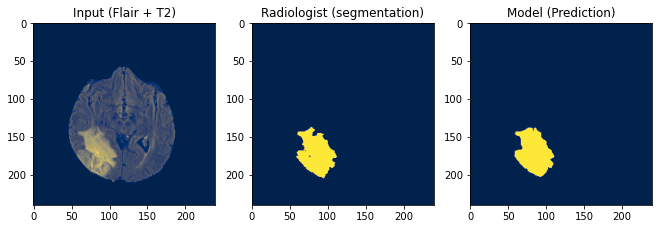

In [14]:
x    = 3500
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4

example = np.expand_dims(x_train[x],axis=0)
pred = model.predict(example)


fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Input (Flair + T2)')
plt.imshow(x_train[x][0],cmap = renk[a])

plt.subplot(142)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(143)
plt.title('Model (Prediction)')
plt.imshow( pred[0][0],cmap = renk[a])

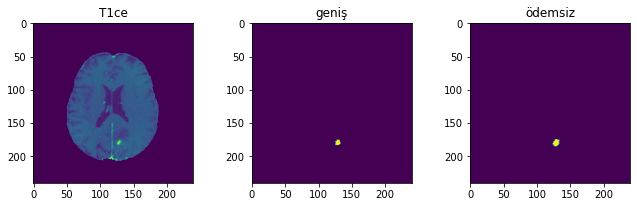

In [19]:
x = 24;
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[x,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(seg_enhancing[x,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(seg_nonedema[x,0,:,:])

In [10]:
def tumor_crop(x, pred, size): 
    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    
    p_tmp[p_tmp !=1] = 0
    index_xy = np.where(p_tmp==1)  

    if index_xy[0].shape[0] == 0: 
        return [],[]
        
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2 
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8
        
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  #64x64
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  #64x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:  #128x64       
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  #128x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy

In [160]:
layer = 11370

image_example_1, coordinate_1 = tumor_crop(t1ce[layer,:,:,:],seg[layer,:,:,:],64)
image_example_2, coordinate_2 = tumor_crop(seg_enhancing[layer,:,:,:],seg[layer,:,:,:],64)
image_example_3, coordinate_3 = tumor_crop(seg_nonedema[layer,:,:,:],seg[layer,:,:,:],64)

t1ce.shape


(12320, 1, 240, 240)

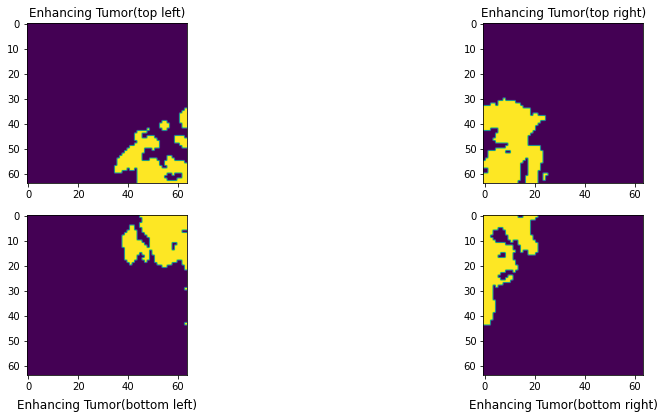

In [116]:
plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
plt.title('Enhancing Tumor(top left)')
plt.imshow(image_example_2[0,0,:,:])

plt.subplot(3,2,3)
plt.title('Enhancing Tumor(bottom left)',y=-0.25)
plt.imshow(image_example_2[1,0,:,:])

plt.subplot(3,2,2)
plt.title('Enhancing Tumor(top right)')
plt.imshow(image_example_2[2,0,:,:])

plt.subplot(3,2,4)
plt.title('Enhancing Tumor(bottom right)',y=-0.25)
plt.imshow(image_example_2[3,0,:,:])

In [9]:
def tumor2array(tumor,segmentasyon):

    liste = []

    for i in range(len(tumor)):
        crop , coordinate_x = tumor_crop(tumor[i,:,:,:],segmentasyon[i,:,:,:],64)
    
        if crop == []:
            pass
        elif crop.shape[0] ==1:
            liste.append(crop[0])
        
        elif crop.shape[0] ==2:
        
           liste.append(crop[0])
           liste.append(crop[1])
        
        elif crop.shape[0] ==4:
        
            liste.append(crop[0])
            liste.append(crop[1])
            liste.append(crop[2])
            liste.append(crop[3]) 
    
    return np.array(liste)

In [10]:
t1ce_array = tumor2array(t1ce,seg)
enhancing_array = tumor2array(seg_enhancing,seg)
odemsiz_array = tumor2array(seg_nonedema,seg)

<ipython-input-9-1820e48c545c>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if crop == []:


In [9]:
K.set_image_data_format('channels_first')

def dice_coef(y_true, y_pred): #[piksel farki] https://i.stack.imgur.com/OsH4y.png
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [14]:
model_odemsiz = unet_model_7()

In [213]:
history = model_odemsiz.fit(t1ce_array, odemsiz_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
2471/2471 [==============================] - 149s 57ms/step - loss: 0.3996 - dice_coef: 0.6004 - val_loss: 0.4374 - val_dice_coef: 0.5623
Epoch 2/5
2471/2471 [==============================] - 141s 57ms/step - loss: 0.2043 - dice_coef: 0.7957 - val_loss: 0.4063 - val_dice_coef: 0.5934
Epoch 3/5
2471/2471 [==============================] - 144s 58ms/step - loss: 0.1728 - dice_coef: 0.8272 - val_loss: 0.4135 - val_dice_coef: 0.5863
Epoch 4/5
2471/2471 [==============================] - 150s 61ms/step - loss: 0.1480 - dice_coef: 0.8520 - val_loss: 0.4043 - val_dice_coef: 0.5954
Epoch 5/5
2471/2471 [==============================] - 159s 64ms/step - loss: 0.1399 - dice_coef: 0.8601 - val_loss: 0.3819 - val_dice_coef: 0.6181


In [215]:
model_odemsiz.save_weights('D://modelweight//model_odemsiz_array.h5')

In [12]:
model_enhancing = unet_model_7()

In [11]:
history = model_enhancing.fit(t1ce_array, enhancing_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
2471/2471 [==============================] - 148s 57ms/step - loss: 0.4744 - dice_coef: 0.5256 - val_loss: 0.5063 - val_dice_coef: 0.4934
Epoch 2/5
2471/2471 [==============================] - 140s 57ms/step - loss: 0.1969 - dice_coef: 0.8031 - val_loss: 0.4930 - val_dice_coef: 0.5068
Epoch 3/5
2471/2471 [==============================] - 143s 58ms/step - loss: 0.1654 - dice_coef: 0.8346 - val_loss: 0.4683 - val_dice_coef: 0.5315
Epoch 4/5
2471/2471 [==============================] - 147s 60ms/step - loss: 0.1569 - dice_coef: 0.8431 - val_loss: 0.4894 - val_dice_coef: 0.5104
Epoch 5/5
2471/2471 [==============================] - 153s 62ms/step - loss: 0.1533 - dice_coef: 0.8467 - val_loss: 0.4435 - val_dice_coef: 0.5563


In [12]:
model_enhancing.save_weights('D://modelweight//model_enhancing_array.h5')

In [15]:
model_enhancing.load_weights('D://modelweight//model_enhancing_array.h5')
model_odemsiz.load_weights('D://modelweight//model_odemsiz_array.h5')
model.load_weights('D://modelweight//final.h5')

In [117]:
x = 11370
image_example , coordinate = tumor_crop(t1ce[x,:,:,:],seg[x,:,:,:],64)

In [118]:
pred_nonedema = model_odemsiz.predict(image_example)
pred_enhancing = model_enhancing.predict(image_example)
pred_tam = model.predict(x_train[x:11371,:,:,:])

In [119]:
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0

pred_nonedema[pred_nonedema > 0.2] = 1
pred_nonedema[pred_nonedema != 1 ] = 0

pred_enhancing[pred_enhancing > 0.2] = 4
pred_enhancing[pred_enhancing != 4 ] = 0

In [120]:
def add_on(pred_tam, pred_nonedema , pred_enhancing , coordinate):  
    
    total = np.zeros((1,240,240),np.float32)  
    total[:,:,:] = pred_tam[:,:,:]
    
    for i in range(pred_nonedema.shape[0]):
        for j in range(64):
            for k in range(64):
                
                if pred_nonedema[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_nonedema[i,0,j,k]
                    
                if pred_enhancing[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_enhancing[i,0,j,k]
                
    return total

In [85]:
example = add_on(pred_tam[0,:,:,:], pred_nonedema, pred_enhancing, coordinate)

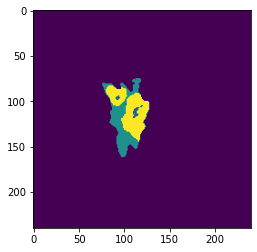

In [86]:
plt.imshow(example[0])

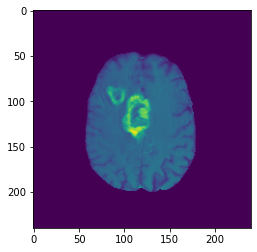

In [87]:
plt.imshow(t1ce[15300,0,:,:])

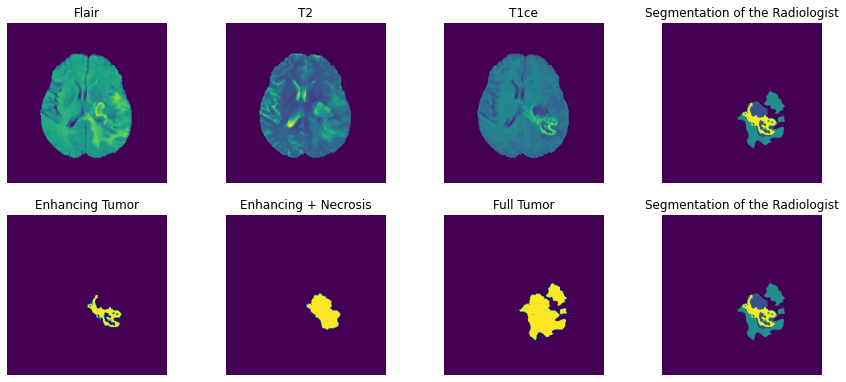

In [185]:
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 1
x = 10800

image_example , coordinate = tumor_crop(t1ce[x,:,:,:],seg[x,:,:,:],64)
pred_nonedema = model_odemsiz.predict(image_example)
pred_enhancing = model_enhancing.predict(image_example)
pred_tam = model.predict(x_train[x-1:x,:,:,:])
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0
pred_nonedema[pred_nonedema > 0.2] = 1
pred_nonedema[pred_nonedema != 1 ] = 0
pred_enhancing[pred_enhancing > 0.2] = 4
pred_enhancing[pred_enhancing != 4 ] = 0
example = add_on(pred_tam[0,:,:,:], pred_nonedema, pred_enhancing, coordinate)


plt.figure(figsize=(15,10))

plt.subplot(341)
plt.title('Flair')
plt.axis('off')
plt.imshow(x_train[x, 0, :, :],cmap= renk[a])

plt.subplot(342)
plt.title('T2')
plt.axis('off')
plt.imshow(x_train[x, 1, :, :],cmap= renk[a])
    
plt.subplot(343)
plt.title('T1ce')
plt.axis('off')
plt.imshow(t1ce[x, 0, :, :],cmap= renk[a])

plt.subplot(344)
plt.title('Segmentation of the Radiologist')
plt.axis('off')
plt.imshow(seg_final[x, 0, :, :],cmap= renk[a])

plt.subplot(345)
plt.title('Enhancing Tumor')
plt.axis('off')
plt.imshow(seg_enhancing[x, 0, :, :],cmap= renk[a])

plt.subplot(346)
plt.title('Enhancing + Necrosis')
plt.axis('off')
plt.imshow(seg_nonedema[x, 0, :, :],cmap= renk[a])

plt.subplot(347)
plt.title('Full Tumor')
plt.axis('off')
plt.imshow(seg[x, 0, :, :],cmap= renk[a])

plt.subplot(348)
plt.title('Segmentation of the Radiologist')
plt.axis('off')
plt.imshow(seg_final[x, 0, :, :],cmap=renk[a])

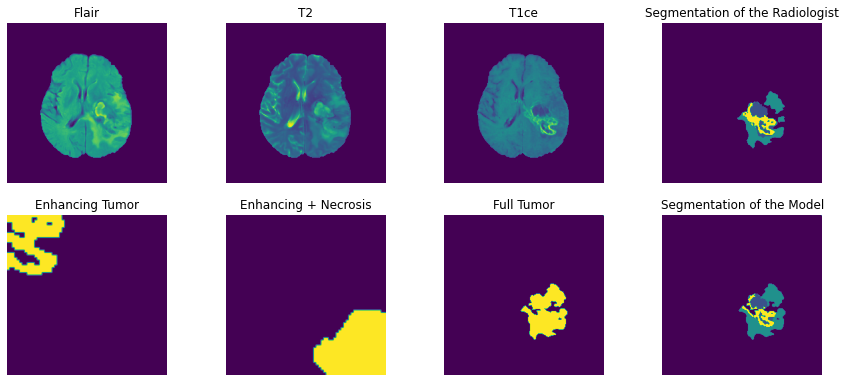

In [182]:
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 1
x = 10800

image_example , coordinate = tumor_crop(t1ce[x,:,:,:],seg[x,:,:,:],64)
pred_nonedema = model_odemsiz.predict(image_example)
pred_enhancing = model_enhancing.predict(image_example)
pred_tam = model.predict(x_train[x-1:x,:,:,:])
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0
pred_nonedema[pred_nonedema > 0.2] = 1
pred_nonedema[pred_nonedema != 1 ] = 0
pred_enhancing[pred_enhancing > 0.2] = 4
pred_enhancing[pred_enhancing != 4 ] = 0
example = add_on(pred_tam[0,:,:,:], pred_nonedema, pred_enhancing, coordinate)


plt.figure(figsize=(15,10))

plt.subplot(341)
plt.title('Flair')
plt.axis('off')
plt.imshow(x_train[x, 0, :, :],cmap= renk[a])

plt.subplot(342)
plt.title('T2')
plt.axis('off')
plt.imshow(x_train[x, 1, :, :],cmap= renk[a])
    
plt.subplot(343)
plt.title('T1ce')
plt.axis('off')
plt.imshow(t1ce[x, 0, :, :],cmap= renk[a])

plt.subplot(344)
plt.title('Segmentation of the Radiologist')
plt.axis('off')
plt.imshow(seg_final[x, 0, :, :],cmap= renk[a])

plt.subplot(345)
plt.title('Enhancing Tumor')
plt.axis('off')
plt.imshow(pred_enhancing[3,0,:,:],cmap= renk[a])

plt.subplot(346)
plt.title('Enhancing + Necrosis')
plt.axis('off')
plt.imshow(pred_nonedema[0, 0, :, :],cmap= renk[a])

plt.subplot(347)
plt.title('Full Tumor')
plt.axis('off')
plt.imshow(pred_tam[0, 0, :, :],cmap= renk[a])

plt.subplot(348)
plt.title('Segmentation of the Model')
plt.axis('off')
plt.imshow(deneme[ 0, :, :],cmap=renk[a])